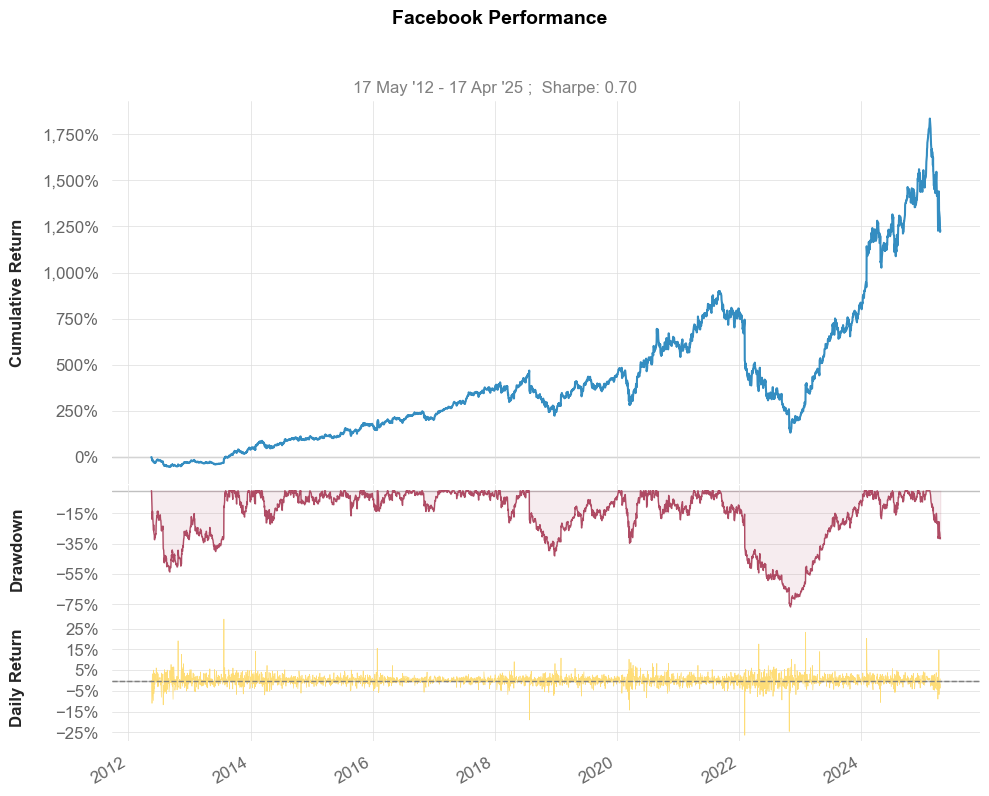

/opt/miniconda3/envs/ml-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/miniconda3/envs/ml-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/miniconda3/envs/ml-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  r

TypeError: Invalid comparison between dtype=datetime64[ns, America/New_York] and datetime

In [1]:
%matplotlib inline
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
stock = qs.utils.download_returns('META')

# show sharpe ratio
qs.stats.sharpe(stock)

# or using extend_pandas() :)
stock.sharpe()

qs.plots.snapshot(stock, title='Facebook Performance', show=True)

qs.reports.html(stock, "SPY")

In [2]:
import yfinance as yf
import pandas as pd
import quantstats as qs
import warnings
warnings.filterwarnings('ignore')
import sys
import numpy as np

# Print version information
print(f"QuantStats version: {qs.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

# Define tickers and time period
tickers = ['SPY', 'SPUU']
start_date = '2022-01-01'  # Using a longer time period
end_date = '2024-03-31'    # Using confirmed available data

# Download data with yfinance
print(f"Downloading data for {tickers}...")
data = {}
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    if df.empty:
        print(f"Error: No data for {ticker}")
        sys.exit(1)
    data[ticker] = df

# Process data for each ticker
returns = {}
for ticker in tickers:
    # Handle multi-level columns
    if isinstance(data[ticker].columns, pd.MultiIndex):
        data[ticker].columns = data[ticker].columns.droplevel(1)
    
    # Calculate returns
    ret = data[ticker]['Close'].pct_change().dropna()
    ret.name = ticker
    returns[ticker] = ret

# Print data summary
print(f"Data periods: {start_date} to {end_date}")
for ticker in tickers:
    print(f"{ticker} data: {returns[ticker].shape[0]} rows")
    print(f"{ticker} date range: {returns[ticker].index[0]} to {returns[ticker].index[-1]}")

# Create a DataFrame of returns
returns_df = pd.DataFrame(returns)

# Save returns to CSV file (can be helpful for debugging)
returns_df.to_csv('spy_spuu_returns.csv')
print(f"Saved returns to CSV with {len(returns_df)} rows")

# Make sure the returns series have the proper format
# Convert to simple Series rather than DataFrame columns
spy_returns = returns_df['SPY'].copy()
spuu_returns = returns_df['SPUU'].copy()

print("\nVerifying returns data types:")
print(f"SPY returns type: {type(spy_returns)}")
print(f"SPUU returns type: {type(spuu_returns)}")

# Try a basic QS operation first to test if the data format is acceptable
print("\nTesting returns with a basic QuantStats metric...")
try:
    sharpe_spy = qs.stats.sharpe(spy_returns)
    print(f"SPY Sharpe Ratio: {sharpe_spy:.4f} (✓)")
    
    sharpe_spuu = qs.stats.sharpe(spuu_returns)
    print(f"SPUU Sharpe Ratio: {sharpe_spuu:.4f} (✓)")
    
    print("Basic metrics calculation successful!")
except Exception as e:
    print(f"Error calculating metrics: {e}")
    sys.exit(1)

# Now try to generate the tearsheet with a specific format
try:
    print("\nGenerating tearsheet...")
    
    # Convert returns to the exact format expected by QuantStats
    spy_rets = pd.Series(
        spy_returns.values,
        index=spy_returns.index,
        name='SPY',
        dtype=np.float64  # Explicitly set dtype
    )
    
    spuu_rets = pd.Series(
        spuu_returns.values,
        index=spuu_returns.index,
        name='SPUU',
        dtype=np.float64  # Explicitly set dtype
    )
    
    # Make sure we're using Series, not DataFrame
    assert isinstance(spy_rets, pd.Series), "SPY returns must be a Series"
    assert isinstance(spuu_rets, pd.Series), "SPUU returns must be a Series"
    
    # Make sure we have data
    assert not spy_rets.empty, "SPY returns cannot be empty"
    assert not spuu_rets.empty, "SPUU returns cannot be empty"
    
    # Make sure index is DatetimeIndex
    assert isinstance(spy_rets.index, pd.DatetimeIndex), "SPY returns index must be DatetimeIndex"
    assert isinstance(spuu_rets.index, pd.DatetimeIndex), "SPUU returns index must be DatetimeIndex"
    
    # Create the tearsheet with the most basic method
    qs.reports.html(
        returns=spy_rets,     # Returns as a pd.Series
        benchmark=spuu_rets,  # Benchmark as a pd.Series  
        rf=0.0,               # Risk-free rate
        grayscale=False,      # Use color
        title="SPY vs SPUU Performance (Buy and Hold Strategy)",
        output="spy_vs_spuu_tearsheet.html"
    )
    
    print("Tearsheet successfully generated: spy_vs_spuu_tearsheet.html")
    
except ValueError as e:
    print(f"\nValueError in tearsheet generation: {e}")
    
    # Try the most minimal possible form
    print("\nAttempting with minimal configuration...")
    try:
        # Try with only the first parameter
        qs.reports.html(
            returns=spy_rets,
            output="spy_minimal.html"
        )
        print("Minimal tearsheet created: spy_minimal.html")
        
    except Exception as e2:
        print(f"Minimal approach also failed: {e2}")
        
except Exception as e:
    print(f"\nUnexpected error: {e}")
    
print("\nFinished processing.")


[*********************100%***********************]  1 of 1 completed

QuantStats version: 0.0.25
Pandas version: 2.2.3
NumPy version: 1.26.4
YF.download() has changed argument auto_adjust default to True



[*********************100%***********************]  1 of 1 completed


Data periods: 2022-01-01 to 2024-03-31
SPY data: 561 rows
SPY date range: 2022-01-04 00:00:00 to 2024-03-28 00:00:00
SPUU data: 561 rows
SPUU date range: 2022-01-04 00:00:00 to 2024-03-28 00:00:00
Saved returns to CSV with 561 rows

Verifying returns data types:
SPY returns type: <class 'pandas.core.series.Series'>
SPUU returns type: <class 'pandas.core.series.Series'>

Testing returns with a basic QuantStats metric...
SPY Sharpe Ratio: 0.3927 (✓)
SPUU Sharpe Ratio: 0.2677 (✓)
Basic metrics calculation successful!

Generating tearsheet...

Unexpected error: pivot() takes 1 positional argument but 4 were given

Finished processing.
